In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

import datetime
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import math
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from fbprophet import Prophet

np.random.seed(21)

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./data/nl-data.csv')

In [3]:
df.head()

,date,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index,total_cases_diff,people_fully_vaccinated_diff,hosp_patients_diff,total_deaths_diff,total_tests_diff,stringency_index_diff,total_cases_trend,total_cases_seasonal,people_vaccinated_trend,people_vaccinated_seasonal,people_fully_vaccinated_trend,people_fully_vaccinated_seasonal,hosp_patients_trend,hosp_patients_seasonal,total_deaths_trend,total_deaths_seasonal,total_tests_trend,total_tests_seasonal,stringency_index_trend,stringency_index_seasonal,total_cases_seasonal_shift_b_2m,total_cases_seasonal_shift_b_1m,total_cases_seasonal_shift_1m,total_cases_seasonal_shift_2m,total_cases_seasonal_shift_3m,people_vaccinated_seasonal_shift_b_2m,people_vaccinated_seasonal_shift_b_1m,people_vaccinated_seasonal_shift_1m,people_vaccinated_seasonal_shift_2m,people_vaccinated_seasonal_shift_3m,people_fully_vaccinated_seasonal_shift_b_2m,people_fully_vaccinated_seasonal_shift_b_1m,people_fully_vaccinated_seasonal_shift_1m,people_fully_vaccinated_seasonal_shift_2m,people_fully_vaccinated_seasonal_shift_3m,hosp_patients_seasonal_shift_b_2m,hosp_patients_seasonal_shift_b_1m,hosp_patients_seasonal_shift_1m,hosp_patients_seasonal_shift_2m,hosp_patients_seasonal_shift_3m,total_deaths_seasonal_shift_b_2m,total_deaths_seasonal_shift_b_1m,total_deaths_seasonal_shift_1m,total_deaths_seasonal_shift_2m,total_deaths_seasonal_shift_3m,total_tests_seasonal_shift_b_2m,total_tests_seasonal_shift_b_1m,total_tests_seasonal_shift_1m,total_tests_seasonal_shift_2m,total_tests_seasonal_shift_3m,stringency_index_seasonal_shift_b_2m,stringency_index_seasonal_shift_b_1m,stringency_index_seasonal_shift_1m,stringency_index_seasonal_shift_2m,stringency_index_seasonal_shift_3m
0,2020-03-01,4.500000,0.0,0.0,10.000000,0.000000,0.000000,5.560000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-7931.941964,988.445191,0.0,21460.378689,0.0,-3426.279433,-386.675000,69.444092,-955.962500,25.144118,-35745.601786,-8396.889187,13.083286,0.259736,988.445191,988.445191,NaN,NaN,NaN,21460.378689,21460.378689,NaN,NaN,NaN,-3426.279433,-3426.279433,NaN,NaN,NaN,69.444092,69.444092,NaN,NaN,NaN,25.144118,25.144118,NaN,NaN,NaN,-8396.889187,-8396.889187,NaN,NaN,NaN,0.259736,0.259736,NaN,NaN,NaN
1,2020-03-08,106.142857,0.0,0.0,67.142857,0.714286,0.000000,7.938571,101.642857,0.0,57.142857,0.714286,0.000000,2.378571,-3472.616071,-494.241175,0.0,-29927.604682,0.0,2577.078343,218.651786,-0.834777,-495.589286,13.506544,-12303.303571,2690.094332,26.323036,-0.438511,-494.241175,-494.241175,NaN,NaN,NaN,-29927.604682,-29927.604682,NaN,NaN,NaN,2577.078343,2577.078343,NaN,NaN,NaN,-0.834777,-0.834777,NaN,NaN,NaN,13.506544,13.506544,NaN,NaN,NaN,2690.094332,2690.094332,NaN,NaN,NaN,-0.438511,-0.438511,NaN,NaN,NaN
2,2020-03-15,659.285714,0.0,0.0,298.142857,8.428571,2440.000000,37.034286,451.500000,0.0,231.000000,7.000000,2440.000000,29.095714,1811.026786,-1124.247722,0.0,-19818.723730,0.0,1539.673581,764.267857,-36.722277,82.535714,-12.082444,14498.035714,4092.753856,37.053214,-0.040964,-1124.247722,-1124.247722,NaN,NaN,NaN,-19818.723730,-19818.723730,NaN,NaN,NaN,1539.673581,1539.673581,NaN,NaN,NaN,-36.722277,-36.722277,NaN,NaN,NaN,-12.082444,-12.082444,NaN,NaN,NaN,4092.753856,4092.753856,NaN,NaN,NaN,-0.040964,-0.040964,NaN,NaN,NaN
3,2020-03-22,2644.571429,0.0,0.0,1233.571429,89.428571,29273.142857,61.110000,1432.142857,0.0,935.428571,73.285714,21953.142857,24.075714,4602.821429,630.043706,0.0,28285.949723,0.0,-690.472491,1473.660714,-31.887039,307.089286,-26.568218,31041.589286,1614.040999,55.040893,0.219739,630.043706,630.043706,NaN,NaN,NaN,28285.949723,28285.949723,NaN,NaN,NaN,-690.472491,-690.472491,NaN,NaN,NaN,-31.887039,-31.887039,NaN,NaN,NaN,-26.568218,-26.568218,NaN,NaN,NaN,1614.040999,1614.040999,NaN,NaN,NaN,0.219739,0.219739,NaN,NaN,NaN
4,2020-03-29,7663.714286,0.0,0.0,2906.428571,463.142857,52558.000000,78.700000,3033.857143,0.0,1672.857143,292.714286,-27941.428571,17.590000,9118.839286,988

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
N_SPLITS = 3

X = df['date']
Y = df['stringency_index']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

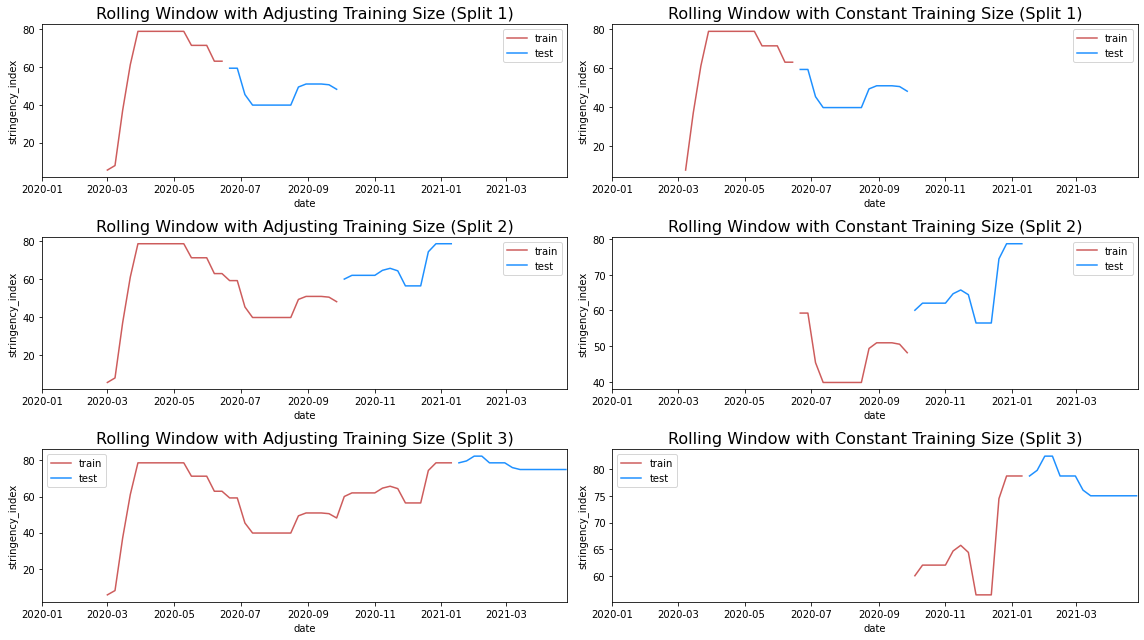

In [6]:
fig, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, test_index) in enumerate(folds.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i, 0],
        color='indianred',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))],
        y=y_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))],
        ax=ax[i, 1],
        color='indianred',
        label='train'
    )
    
    for j in range(2):
        sns.lineplot(
            x=X_test,
            y=y_test,
            ax=ax[i, j],
            color='dodgerblue',
            label='test'
        )
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)
    
for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    ax[i, 1].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    ax[i, 0].ticklabel_format(style='plain', axis='y')
    ax[i, 1].ticklabel_format(style='plain', axis='y')
    
fig.tight_layout()

In [8]:
train_size = int(0.90 * len(df))
test_size = len(df) - train_size

df_upr = df[['date', 'stringency_index']].copy()
df_upr.columns = ['ds', 'y']

train = df_upr.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(df_upr.iloc[:train_size, 0]), pd.DataFrame(df_upr.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(df_upr.iloc[train_size:, 0]), pd.DataFrame(df_upr.iloc[train_size:, 1])

print(len(train), len(x_test))

54 7


In [9]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',
                      max_p=7, max_q=7,
                      max_d=5, max_P=4,
                      max_D=4, max_Q=4,
                      m=4,
                      d=None,
                      seasonal=False,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

/home/mykull/miniconda3/envs/corona/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=353.392, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=362.687, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=351.401, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=354.206, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=362.498, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=353.383, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=354.727, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=350.024, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=352.013, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=352.018, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=353.248, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=353.324, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.261 seconds
                               SARIMAX Results                                
Dep. Variable:       

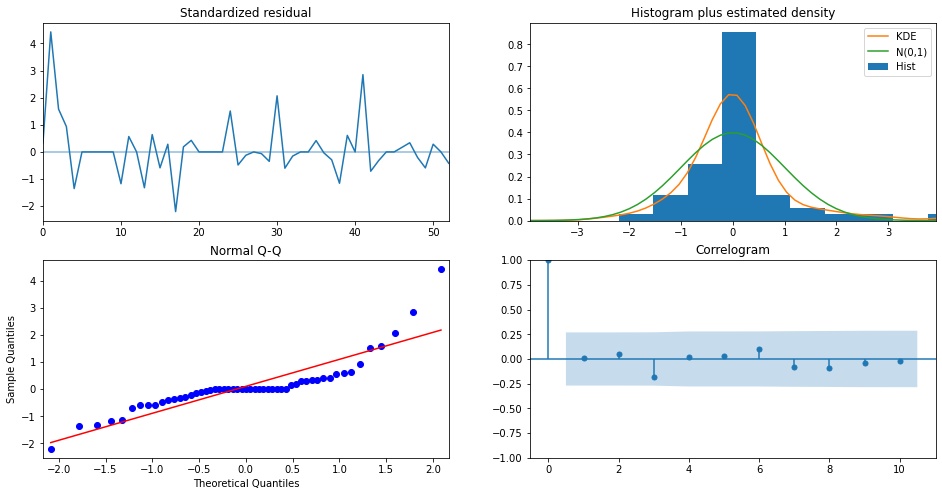

In [10]:
model.plot_diagnostics(figsize=(16, 8));

In [11]:
model = Prophet()
model.fit(train)

y_pred=model.predict(x_test)

score_mae = mean_absolute_error(y_test, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 0.8855881858734146


Text(104.875, 0.5, 'Stringency Index')

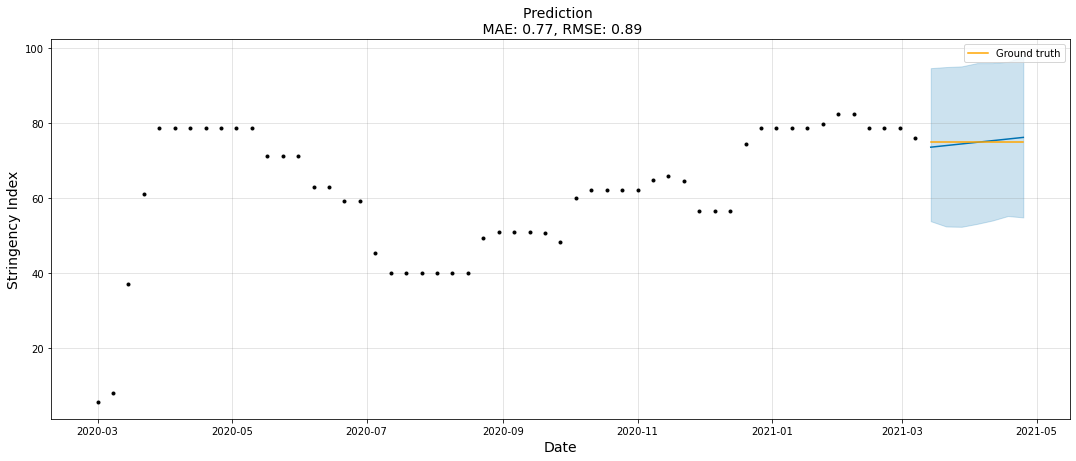

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)

In [13]:
model = ARIMA(y_train, order=(1,1,0))
model_fit = model.fit()

y_pred, se, conf = model_fit.forecast(7)

score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 3.8167373229861847


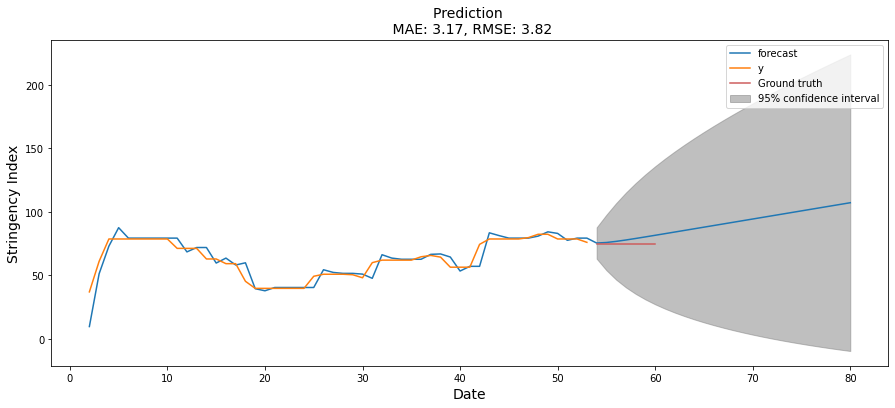

In [14]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

model_fit.plot_predict(2, 80, ax=ax)
sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='indianred', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')

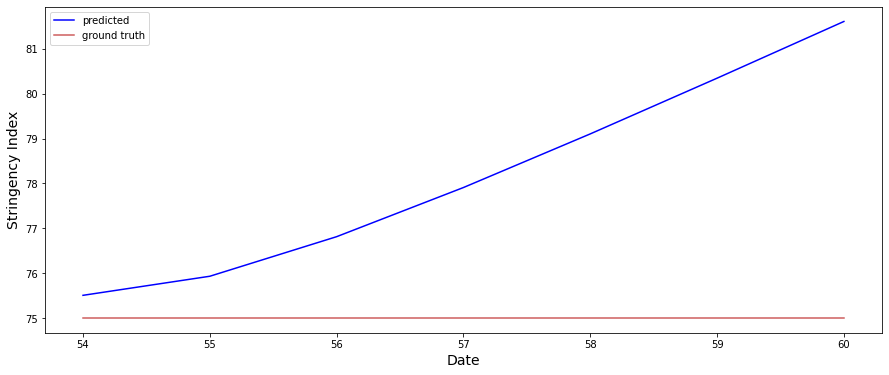

In [15]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

sns.lineplot(x=x_test.index, y=y_pred, ax=ax, color='blue', label='predicted')
sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='indianred', label='ground truth')

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')

In [16]:
feature_columns = [
    'total_cases',
    'people_vaccinated',
    'people_fully_vaccinated',
    'hosp_patients',
    'total_deaths',
    'total_tests',
    #'stringency_index'
]
target_column = ['stringency_index']

train_size = int(0.85 * len(df))

df_mpr = df[['date'] + target_column + feature_columns].copy()
df_mpr.columns = ['ds', 'y'] + feature_columns

train = df_mpr.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(df_mpr.iloc[:train_size, [0,2,3,4,5,6,7]]), pd.DataFrame(df_mpr.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(df_mpr.iloc[train_size:, [0,2,3,4,5,6,7]]), pd.DataFrame(df_mpr.iloc[train_size:, 1])

In [29]:
model = Prophet()

model.add_regressor('total_cases')
model.add_regressor('people_vaccinated')
#model.add_regressor('people_fully_vaccinated')
#model.add_regressor('hosp_patients')
#model.add_regressor('total_deaths')
#model.add_regressor('total_tests')
#model.add_regressor('stringency_index')

model.fit(train)

y_pred = model.predict(x_test)

score_mae = mean_absolute_error(y_test, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 5.220328216347708


Text(104.875, 0.5, 'Stringency Index')

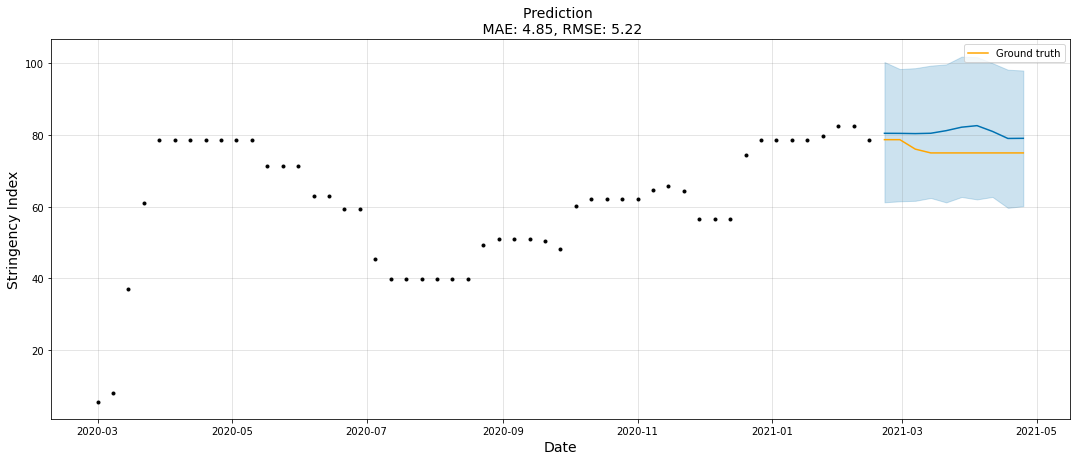

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

model.plot(y_pred, ax=ax)

sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)

In [31]:
future = model.make_future_dataframe(periods=150)
future.tail()

,ds
196,2021-07-10
197,2021-07-11
198,2021-07-12
199,2021-07-13
200,2021-07-14
